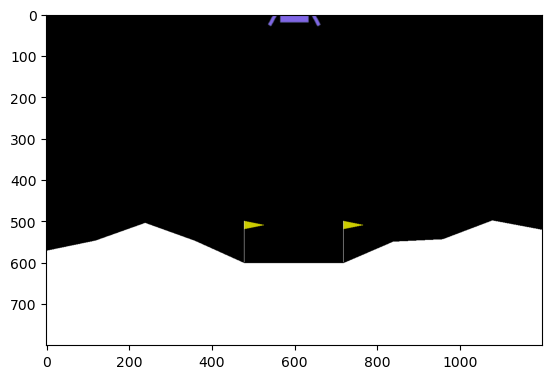

In [1]:
import os
import gym
import matplotlib.pyplot as plt
# os.environ["SDL_VIDEODRIVER"] = "dummy"
os.environ["SDL_VIDEODRIVER"] = "x11"
# from IPython.display import clear_output
from IPython import display

env = gym.make("LunarLander-v2")#, render_mode="human")
env.action_space.seed(42)
env.reset()
img = plt.imshow(env.render(mode='rgb_array'))

for _ in range(1000):
    observation, reward, done, info = env.step(env.action_space.sample())

    if done:
        env.reset()
        break
        
#     clear_output(wait=True)
#     plt.imshow( env.render(mode='rgb_array') )
#     plt.show()
#     img.set_data(env.render(mode='rgb_array'))
#     display.display(plt.gcf())
#     display.clear_output(wait=True)

env.close()

In [9]:
env.observation_space, env.action_space

(Box([-inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf], (8,), float32),
 Discrete(4))

In [17]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.distributions import Categorical
import torch.optim as optim

In [177]:
class NetWork(nn.Module):
    def __init__(self, hidden=16):
        super().__init__()
        self.fc1 = nn.Linear(8, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, 4)
    
    def forward(self, state):
        '''
          input N * observation_space
        '''
        x = F.tanh(self.fc1(state))
        x = F.tanh(self.fc2(x))
        return F.softmax(self.fc3(x), dim=-1)

In [260]:
m = Categorical(torch.tensor([4,5,1,6]))
m.probs[3]

tensor(0.3750)

In [223]:
class PolicyGradientAgent():
    def __init__(self, network, lr=1e-4, eps=0.5):
        self.network = network
        self.optimizer = optim.Adam(self.network.parameters(), lr=lr)
        self.eps = eps        
    
    def learn(self, log_prob, award):
        '''
          loss = - sum(award * log_prob)
          note: award are constant within the loop, the only thing that needs to be on the graph is log_prob
        '''
        loss = -(log_prob * award).sum()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def sample(self, state):
        probs = self.network(torch.Tensor(state))
        m = Categorical(probs)
        if np.random.rand() < self.eps:
            action = torch.tensor(np.random.choice(4)).to(torch.int32)
        else:
            action = m.sample()
        log_prob = m.log_prob(action)
        return action.item(), log_prob

In [59]:
observation, reward, done, info = env.step(env.action_space.sample())

In [60]:
observation, reward

(array([ 0.00561829,  1.4005466 ,  0.29008743, -0.24361031, -0.00834395,
        -0.1028451 ,  0.        ,  0.        ], dtype=float32),
 -2.387169478805872)

In [61]:
agent = PolicyGradientAgent(NetWork())

In [77]:
action, log_prob = agent.sample(observation)
action, log_prob

(1, tensor(-1.4346, grad_fn=<SqueezeBackward1>))

In [78]:
agent.learn(log_prob, reward)

### do some training

In [47]:
from tqdm import tqdm
import numpy as np

In [48]:
rewards = np.array([1,2,3])
GAMMA = 0.99

In [83]:
facs = np.array([GAMMA**i for i in range(100000)])

In [98]:
facs[:100]

array([1.        , 0.99      , 0.9801    , 0.970299  , 0.96059601,
       0.95099005, 0.94148015, 0.93206535, 0.92274469, 0.91351725,
       0.90438208, 0.89533825, 0.88638487, 0.87752102, 0.86874581,
       0.86005835, 0.85145777, 0.84294319, 0.83451376, 0.82616862,
       0.81790694, 0.80972787, 0.80163059, 0.79361428, 0.78567814,
       0.77782136, 0.77004315, 0.76234271, 0.75471929, 0.74717209,
       0.73970037, 0.73230337, 0.72498034, 0.71773053, 0.71055323,
       0.70344769, 0.69641322, 0.68944909, 0.6825546 , 0.67572905,
       0.66897176, 0.66228204, 0.65565922, 0.64910263, 0.6426116 ,
       0.63618549, 0.62982363, 0.62352539, 0.61729014, 0.61111724,
       0.60500607, 0.59895601, 0.59296645, 0.58703678, 0.58116641,
       0.57535475, 0.5696012 , 0.56390519, 0.55826614, 0.55268348,
       0.54715664, 0.54168508, 0.53626823, 0.53090554, 0.52559649,
       0.52034052, 0.51513712, 0.50998575, 0.50488589, 0.49983703,
       0.49483866, 0.48989027, 0.48499137, 0.48014146, 0.47534

In [88]:
np.log(0.1), np.log(0.999), np.log(0.25)

(-2.3025850929940455, -0.0010005003335835344, -1.3862943611198906)

In [197]:
gamma = 0.99
r = np.array([1,2,3])
tmp = 0
for x in r[::-1]:
    tmp = gamma*tmp + x
    print(tmp)

3.0
4.97
5.9203


In [204]:
tmp = facs[:len(r)][::-1]
(np.cumsum(r[::-1]*tmp) / tmp)[::-1]

array([5.9203, 4.97  , 3.    ])

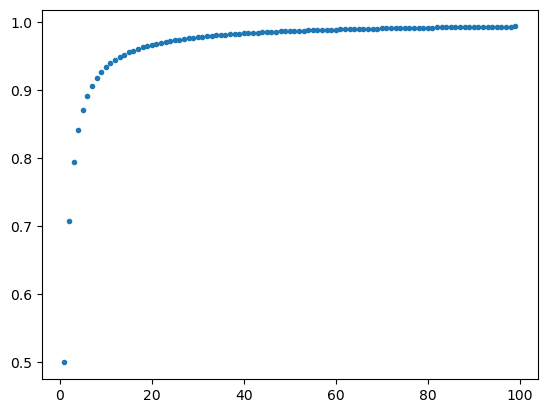

In [214]:
n = np.arange(1,100)
plt.plot(n, np.exp(np.log(0.5)/n), '.')

In [170]:
0.5/500

0.001

In [251]:
agent = PolicyGradientAgent(NetWork(), lr=1e-2)
agent.eps = 0.0
agent.network.train()
EPISODE_PER_BATCH = 10
NUM_BATCH = 500
GAMMA = 0.99

progress_bar = tqdm(range(NUM_BATCH))
output_rewards = []
output_length = []

for batch in progress_bar:
    
    # collect trajectory
    all_rewards, all_log_probs, tmp = [], [], 0    
    for episode in range(EPISODE_PER_BATCH):
        state, total_reward = env.reset(), 0
        rewards = []
        
#         while True:
        for _ in range(2000):
#         for _ in range(500):  # does this work?
            action, log_prob = agent.sample(state)
            state, reward, done, _ = env.step(action)
            all_log_probs.append(log_prob)
            rewards.append(reward)
            if done:
                break
        
        all_rewards.append(np.array(rewards))
        tmp += np.sum(rewards)
    output_rewards.append(tmp/EPISODE_PER_BATCH)
    output_length.append(len(all_log_probs)/EPISODE_PER_BATCH)
#     print(f"all_rewards: {all_rewards}")
    
    # I think it's better to first calculate the discount then take out the avg
    all_rewards_discounted = []
    for reward in all_rewards:
        tmp = facs[:len(reward)][::-1]
        reward = (np.cumsum(reward[::-1]*tmp) / tmp)[::-1]
        reward = reward - 0.1*len(reward)  # does this work?
        all_rewards_discounted.append(reward)
    
    all_rewards_discounted = np.hstack(all_rewards_discounted)
    all_rewards_discounted = (all_rewards_discounted - np.mean(all_rewards_discounted)) \
         / (np.std(all_rewards_discounted) + 1e-9)
    all_log_probs = torch.stack(all_log_probs)
#     print(all_log_probs, all_rewards_discounted)
    progress_bar.set_description(f"mean reward: {output_rewards[-1]}" +\
                                 f"mean length: {output_length[-1]}")
    agent.learn(all_log_probs, torch.tensor(all_rewards_discounted))
    
#     agent.eps -= 0.001/2

mean reward: 71.3292855245372mean length: 310.9:  62%|█████████████████████████████████████████████████▍                              | 309/500 [19:51<12:16,  3.86s/it]


KeyboardInterrupt: 

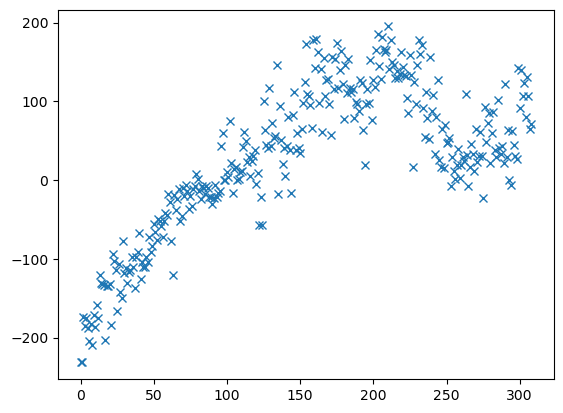

In [252]:
plt.plot(output_rewards,'x')

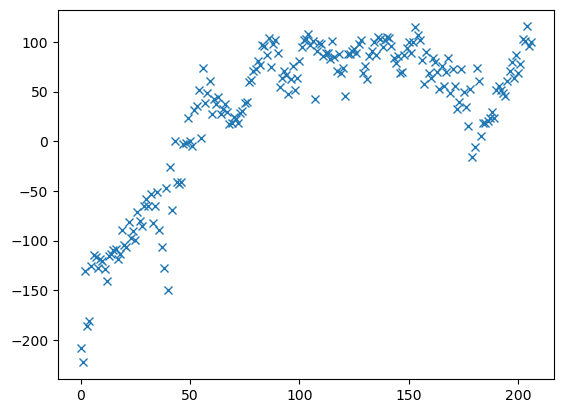

In [246]:
plt.plot(output_rewards,'x')

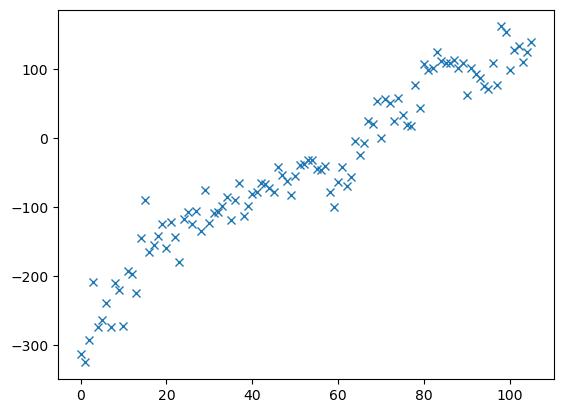

In [235]:
plt.plot(output_rewards,'x')

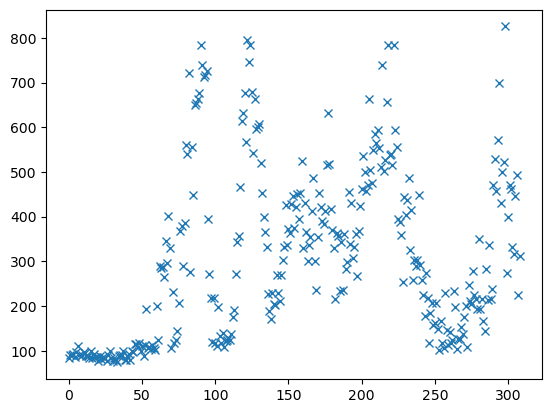

In [253]:
plt.plot(output_length,'x')

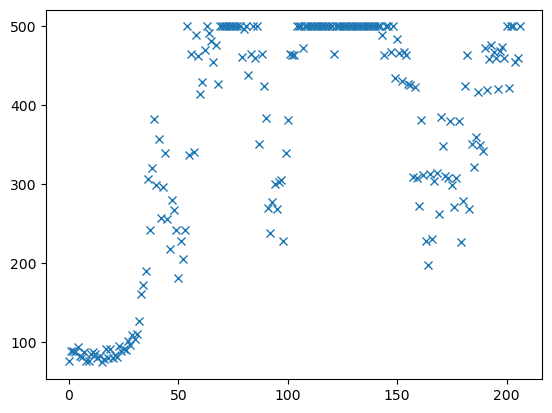

In [247]:
plt.plot(output_length,'x')

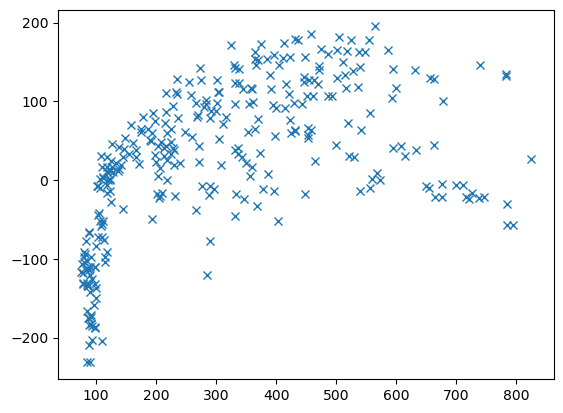

In [254]:
plt.plot(output_length, output_rewards, 'x')

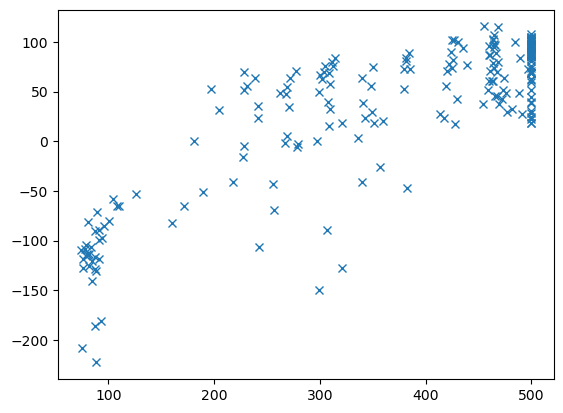

In [248]:
plt.plot(output_length, output_rewards, 'x')

KeyboardInterrupt: 

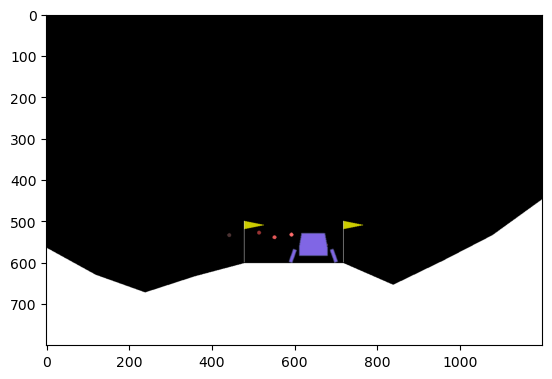

In [250]:
env.reset()
agent.network.eval()
img = plt.imshow(env.render(mode='rgb_array'))

total_reward = 0
for _ in range(1000):
    action, _ = agent.sample(state)
    state, reward, done, info = env.step(action)
    total_reward += reward

    if done:
        env.reset()
        break
        
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

print(f'total_reward={total_reward}')
env.close()

### try PPO

In [263]:
torch.min(torch.tensor((1,2,3)), torch.tensor((4,5,0)))

tensor([1, 2, 0])

In [378]:
agent = PolicyGradientAgent_PPO(NetWork(), lr=1e-2, K=10)
agent.network.train()
EPISODE_PER_BATCH = 10
NUM_BATCH = 500
GAMMA = 0.99
Tmax = 1000

progress_bar = tqdm(range(NUM_BATCH))
output_rewards = []
output_length = []

for batch in progress_bar:
    
    # collect trajectory
    all_rewards, all_probs, all_states, all_actions, actual_reward = [], [], [], [], 0
    for episode in range(EPISODE_PER_BATCH):

        rewards, state = [], env.reset()
        for _ in range(Tmax):
            state = torch.tensor(state)
            all_states.append(state)      
            action, prob = agent.sample(state)
            state, reward, done, _ = env.step(action)
            all_probs.append(prob)
            all_actions.append(action)
            rewards.append(reward)
            if done:
                break
        
        actual_reward += np.sum(rewards)
    
        # discount the rewards
        rewards = np.array(rewards)[::-1]
        tmp = facs[:len(rewards)][::-1]
        rewards = (np.cumsum(rewards * tmp) / tmp)[::-1]
        all_rewards.append(rewards)
    
    # this bit is for the output
    output_rewards.append(actual_reward/EPISODE_PER_BATCH)
    output_length.append(len(all_probs)/EPISODE_PER_BATCH)
    
    # normalize the all_rewards
    all_rewards = np.hstack(all_rewards)
    all_rewards = (all_rewards - np.mean(all_rewards)) / (np.std(all_rewards) + 1e-9)
    all_rewards = torch.tensor(all_rewards)
    all_probs = torch.stack(all_probs)
    all_states = torch.stack(all_states)
    all_actions = torch.tensor(all_actions)
#     print(f"checking shape: {all_rewards.shape} {all_probs.shape} {all_states.shape} {all_actions.shape}")
    
    progress_bar.set_description(f"mean reward: {output_rewards[-1]}" +\
                                 f"mean length: {output_length[-1]}")
    
    
    agent.learn(all_states, all_actions, all_rewards, all_probs)
    
#     agent.eps -= 0.001/2

mean reward: 95.1746041549311mean length: 533.4:  82%|█████████████████████████████████████████████████████████████████▌              | 410/500 [49:19<10:49,  7.22s/it]


KeyboardInterrupt: 

In [377]:
class PolicyGradientAgent_PPO():
    def __init__(self, network, lr=1e-4, eps=0.2, K=10):
        self.network = network
        self.optimizer = optim.Adam(self.network.parameters(), lr=lr)
        self.eps = eps     
        self.K = K
    
    def learn(self, state, action, award, prob_old):
        '''
          loss = min(prob/prob_old*A, clip(prob/prob_old)*A)
          note: award are constant within the loop, the only thing that needs to be on the graph is log_prob
        '''
        prob_old = prob_old.detach()
        for _ in range(self.K):
            prob = self.network(state).gather(1, action.reshape(-1,1)).reshape(-1)
            r = prob / prob_old
            r_clipped = torch.clip(r, 1-self.eps, 1+self.eps)
            loss = -torch.min(r*award, r_clipped*award).sum()
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
    
    def sample(self, state):
        probs = self.network(state)
        m = Categorical(probs)
        action = m.sample().item()
        return action, m.probs[action]
#         prob = m.probs.gather(1, action.reshape(-1,1))
#         return action, prob

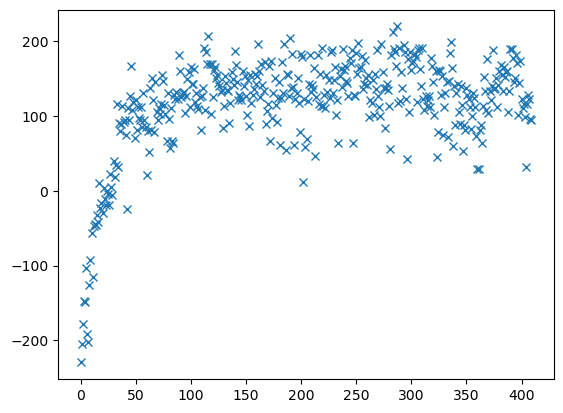

In [379]:
plt.plot(output_rewards, 'x')

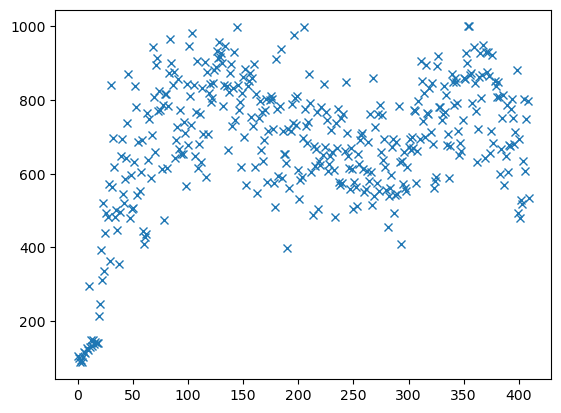

In [381]:
plt.plot(output_length, 'x')

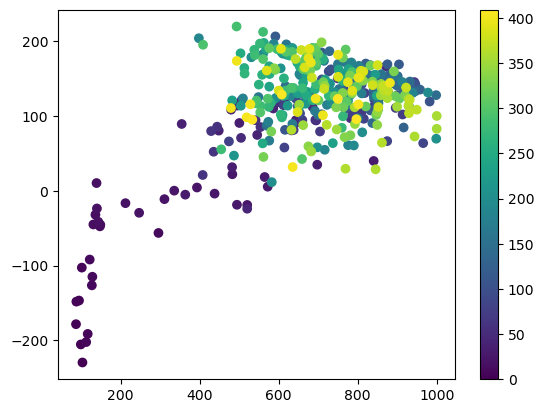

In [384]:
plt.scatter(output_length, output_rewards, c=range(len(output_length)))
plt.colorbar()